In [13]:
import pandas as pd
import numpy as np
import datetime
import netCDF4
import matplotlib.pyplot as plt
%matplotlib notebook

In [14]:
# Import CDIP201 archive covering Feb-Aug 2020
# Open local copy of netCDF archive file
p2rtfile = r'201p1_rt_FebAug2020.nc'

ds = netCDF4.Dataset(p2rtfile)
ds.set_always_mask(False)

# Create pandas DataFrame for these guys
dsTime = ds.variables['waveTime'][:]
timeall = [datetime.datetime.fromtimestamp(t) for t in dsTime] # Convert ncTime variable to datetime stamps
Hs = ds.variables['waveHs'][:]
Tp = ds.variables['waveTp'][:]
Dp = ds.variables['waveDp'][:] 

data = {'t':dsTime,'dt':timeall,'Hs':Hs,'Tp':Tp,'Dp':Dp}
ns = pd.DataFrame(data)
ns = ns.set_index('t')

# round down to half hour
# CDIP data usual reports time at xx:03:35 or xx:33:45
ns['thh'] = ns.index
ns.thh= ns.thh.apply(lambda ti: ti - (ti%1800))
ns = ns.set_index('thh')

# Spectral axis variables (of size (rows,64) or (64,))
Ed = ds.variables['waveEnergyDensity'][:] #band energy density (m*m/hz)
Fq = ds.variables['waveFrequency'][:] #band center frequency
bw = ds.variables['waveBandwidth'][:]
A1 = ds.variables['waveA1Value'][:]
B1 = ds.variables['waveB1Value'][:]
A2 = ds.variables['waveA2Value'][:]
B2 = ds.variables['waveB2Value'][:]


<IPython.core.display.Javascript object>


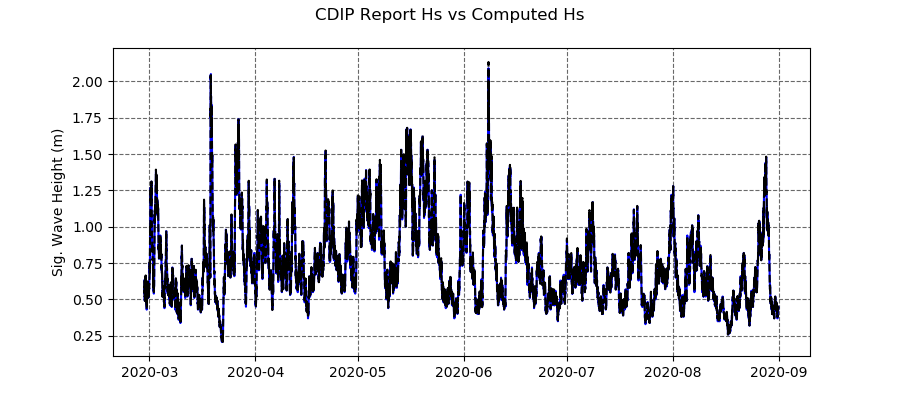

In [15]:
# To confirm that the spectral data matches the bulk parameters, 
# we can recompose the significant wave height from the energy conent in each frequency band

# Derived Series
Eb = Ed*bw # energy in contained in bands
m0 = np.sum(Eb,1) # 0th moment, sum of all energy in the spectrum for each time step. Premier among the "First 5"
H13 = 4*np.sqrt(m0) # Hs = H13

f,pHs = plt.subplots(1,1,figsize=(9,4),num='CDIP Report Hs vs Computed Hs')
plt.suptitle('CDIP Report Hs vs Computed Hs',fontsize=12)

pHs.plot(ns.dt,ns.Hs,'b-')
pHs.plot(ns.dt,H13,'k--')
pHs.set_ylabel('Sig. Wave Height (m)')
pHs.grid(b=True, which='major', color='dimgrey', linestyle='--')


In [16]:
#%% Open allCoastScout "first 5" files and combine into two time ranges
#   20200318T181000Z UTC - 20200319T064000Z UTC
#   20200807T181000Z - 20200808T051000Z
    
all_f5_data_folder = r'Scripps02FourierCoefficients'

import os
f5_folders = os.listdir(all_f5_data_folder)
march_f5_folders = [os.path.join(all_f5_data_folder,folder,r'fourier_coefficients.csv') for i,folder in enumerate(f5_folders) if folder[4:6]=='03']
aug_f5_folders = [os.path.join(all_f5_data_folder,folder,r'fourier_coefficients.csv') for i,folder in enumerate(f5_folders) if folder[4:6]=='08']
    
marf5 = pd.concat(pd.read_csv(f,skiprows=9,header=None,index_col=False,names=['Hz','mms','a1','b1','a2','b2']) for f in march_f5_folders[23:24])
#augf5 = pd.concat(pd.read_csv(f,skiprows=9,header=None,index_col=False,names=['Hz','mms','a1','b1','a2','b2']) for f in aug_f5_folders[22:23])

In [12]:
#Binder only...uncomment the line below and use Cell->Run and Cell->Run All Below to fix an unresolve indexing issue caused by Binder
marf5 = pd.concat(pd.read_csv(f,skiprows=9,header=None,index_col=False,names=['Hz','mms','a1','b1','a2','b2']) for f in march_f5_folders[:1])

<IPython.core.display.Javascript object>


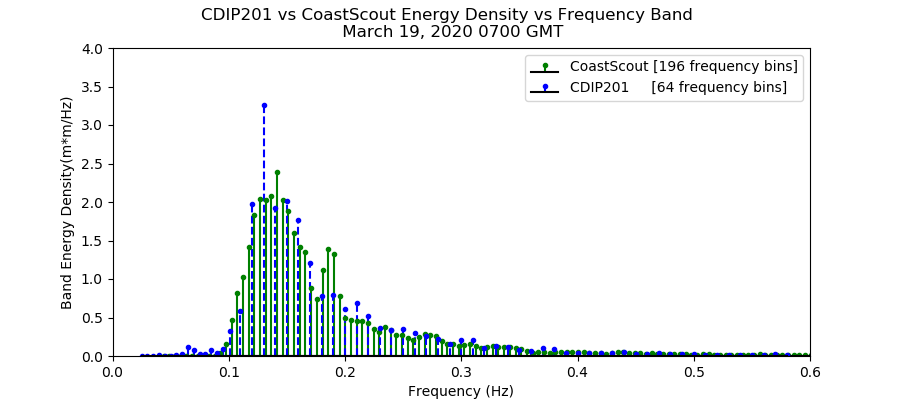

Text(0, 0.5, 'Band Energy Density(m*m/Hz)')

In [5]:
# Compare a single half-hour record
# 1584556200 = March 18, 2020 18:30:00 GMT = CDIP201 archive record 903
# 1584601200 = March 19, 2020 07:00:00 GMT = CDIP201 archive record 928
icdip = 928

f,pStem = plt.subplots(1,1,figsize=(9,4),num='Energy Density vs Frequency')
plt.suptitle('CDIP201 vs CoastScout Energy Density vs Frequency Band \n March 19, 2020 0700 GMT',fontsize=12)

pStem.stem(marf5.Hz,marf5.mms,linefmt='g-',markerfmt='g.',basefmt='k',use_line_collection=True)
pStem.stem(Fq,Ed[icdip,:],linefmt='b--',markerfmt='b.',basefmt='k',use_line_collection=True)
pStem.legend(['CoastScout [196 frequency bins]','CDIP201     [64 frequency bins]'])
pStem.set_xlim([0,0.6])
pStem.set_xlabel('Frequency (Hz)')
pStem.set_ylim([0,4.])
pStem.set_ylabel('Band Energy Density(m*m/Hz)')


<IPython.core.display.Javascript object>


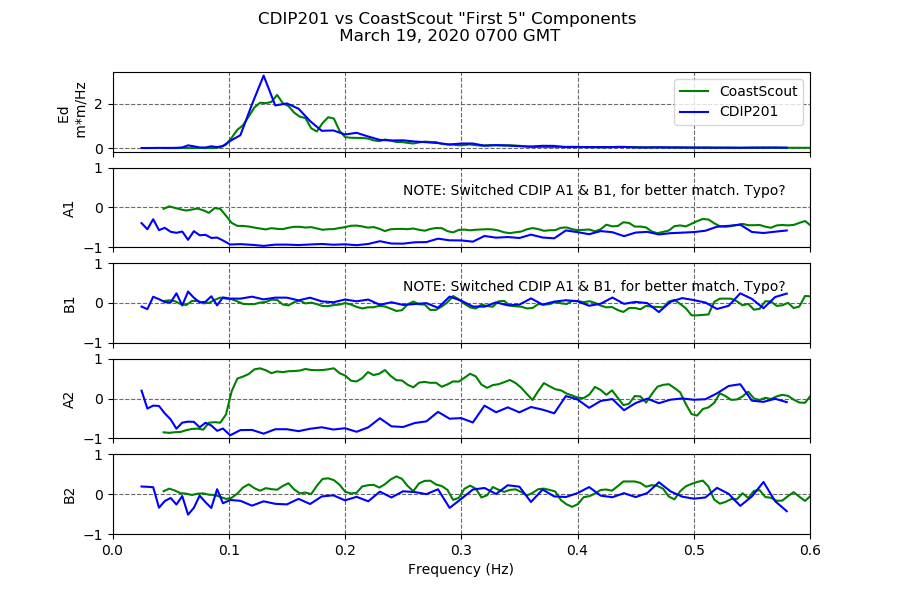

Text(0.5, 0, 'Frequency (Hz)')

In [6]:
# Plot First 5 as a function of Frequency

f, (pEd,pA1,pB1,pA2,pB2) = plt.subplots(5,1,sharex=True,figsize=(9,6),num='CDIP201 vs CoastScout, "First 5" Components')
plt.suptitle('CDIP201 vs CoastScout "First 5" Components \n March 19, 2020 0700 GMT \n',fontsize=12)

pEd.plot(marf5.Hz,marf5.mms,'g-')
pEd.plot(Fq,Ed[icdip,:],'b-')
pEd.set_ylabel('Ed \n m*m/Hz')
pEd.grid(b=True, which='major', color='dimgrey', linestyle='--')
pEd.legend(['CoastScout','CDIP201'])
pEd.set_xlim([0,0.6])

pA1.plot(marf5.Hz,marf5.a1,'g-')
pA1.plot(Fq,B1[icdip,:],'b-')
pA1.text(0.25,0.3,'NOTE: Switched CDIP A1 & B1, for better match. Typo?')
pA1.set_ylabel('A1')
pA1.set_ylim([-1,1])
pA1.set_yticks([-1,0,1])
pA1.set_xlim([0,0.6])
pA1.grid(b=True, which='major', color='dimgrey', linestyle='--')

pB1.plot(marf5.Hz,marf5.b1,'g-')
pB1.plot(Fq,A1[icdip,:],'b-')
pB1.text(0.25,0.3,'NOTE: Switched CDIP A1 & B1, for better match. Typo?')
pB1.set_ylabel('B1')
pB1.set_ylim([-1,1])
pB1.set_yticks([-1,0,1])
pB1.set_xlim([0,0.6])
pB1.grid(b=True, which='major', color='dimgrey', linestyle='--')

pA2.plot(marf5.Hz,marf5.a2,'g-')
pA2.plot(Fq,A2[icdip,:],'b-')

pA2.set_ylabel('A2')
pA2.set_ylim([-1,1])
pA2.set_yticks([-1,0,1])
pA2.set_xlim([0,0.6])
pA2.grid(b=True, which='major', color='dimgrey', linestyle='--')

pB2.plot(marf5.Hz,marf5.b2,'g-')
pB2.plot(Fq,B2[icdip,:],'b-')
pB2.set_ylabel('B2')
pB2.set_ylim([-1,1])
pB2.set_yticks([-1,0,1])
pB2.set_xlim([0,0.6])
pB2.grid(b=True, which='major', color='dimgrey', linestyle='--')
pB2.set_xlabel('Frequency (Hz)')
